# Случайный лес

Цель этого ноутбука &mdash; знакомство со случайными лесами, с их параметрами и свойствами.

In [1]:
import copy
import random
import warnings

import numpy as np
import pandas as pd
import scipy.stats as sps

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

warnings.simplefilter("ignore", DeprecationWarning)
sns.set(context='poster')
%matplotlib inline

np.random.seed(42)

### Основные параметры

**Реализации: `RandomForestClassifier`, `RandomForestRegressor`**

Набор гиперпараметров случайного леса очень похож на набор гиперпараметров решающего дерева. Основным отличием является наличие у случайного леса параметра `n_estimators`, задающего количество решающих деревьев, используемых для получения предсказаний. Это **основной гиперпараметр** для случайного леса.

Напомним главные гиперпараметры решающего дерева, которые также имеются у случайного леса.

* `criterion` — критерий информативности, по которому происходит разбиение вершины дерева.

* `max_depth` — ограничение на глубину каждого дерева в лесе.

* `min_samples_split` — минимальное количество элементов обучающей выборки в вершине дерева, чтобы её можно было разбивать.

* `min_samples_leaf` — минимальное количество элементов обучающей выборке в листовой вершине.

* `splitter` — способ разбиения вершины каждого решающего дерева. Есть 2 возможных варианта: `best` и `random`. В первом случае рассматриваются все возможные способы разбить вершину дерева на две и берётся тот из них, значение критерия для которого оптимально. При `splitter=random` берётся несколько случайных возможных разбиений и среди них выбирается то, значение критерия для которого оптимально.

* `max_features` — максимальное количество признаков, которые могут быть перебраны при разбиении вершины дерева. Перед каждым разбиением дерева генерируется выборка из `min(k, max_features)` случайных признаков (`k` — количество признаков в датасете) и только эти признаки рассматриваются как разделяющие в данной вершине. <br>
Этот признак может принимать
    * целочисленное значение — число признаков,
    * вещественное значение — доля признаков,
    * `None` — все признаки,
    * `"auto"` — квадратный корень от числа всех признаков (по умолчанию),
    * `"sqrt"` — квадратный корень от числа всех признаков,
    * `"log2"` — двоичный логарифм от числа всех признаков.
    
* `min_impurity_decrease` — минимальное значение уменьшения взвешенного критерия неопределенности (`impurity`), чтобы можно было разбить выборку в данной вершине.

О других гиперпараметрах случайного леса можно почитать в <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">документации</a>.

## Решение задачи классификации с помощью Random Forest

Возьмем классический датасет Breast Canser для определения доброкачественной или злокачественной опухоли. Его можно скачать с помощью `sklearn`, а дополнительную информацию о переменных можно почитать <a href="https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+dicancer = load_breast_cancer()
X, y = cancer.data, cancer.targetagnostic">тут</a>.

In [2]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

### Зависимость точности классификации от значений гиперпараметров

Разобьём данные на обучающую и тестовую выборки.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Для начала попробуем оценить оптимальное количество решающих деревьев в лесе, взяв значения всех остальных параметров по умолчанию. Построим график зависимости `accuracy` от `n_estimators` на обучающей и на тестовой выборках. В большинстве случаев, значение `n_estimators` берут в диапазоне от 10 до 100. Но здесь мы рассмотрим более широкий набор значений — от 1 до 200.

In [12]:
n_estimators_values = np.arange(1, 201)

train_accuracies = []
test_accuracies = []

for n in n_estimators_values:
    clf = RandomForestClassifier(n_estimators = n, random_state = 42)
    clf.fit(X_train, y_train)

    train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    train_accuracies.append(train_accuracy)

    test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_accuracies.append(test_accuracy)

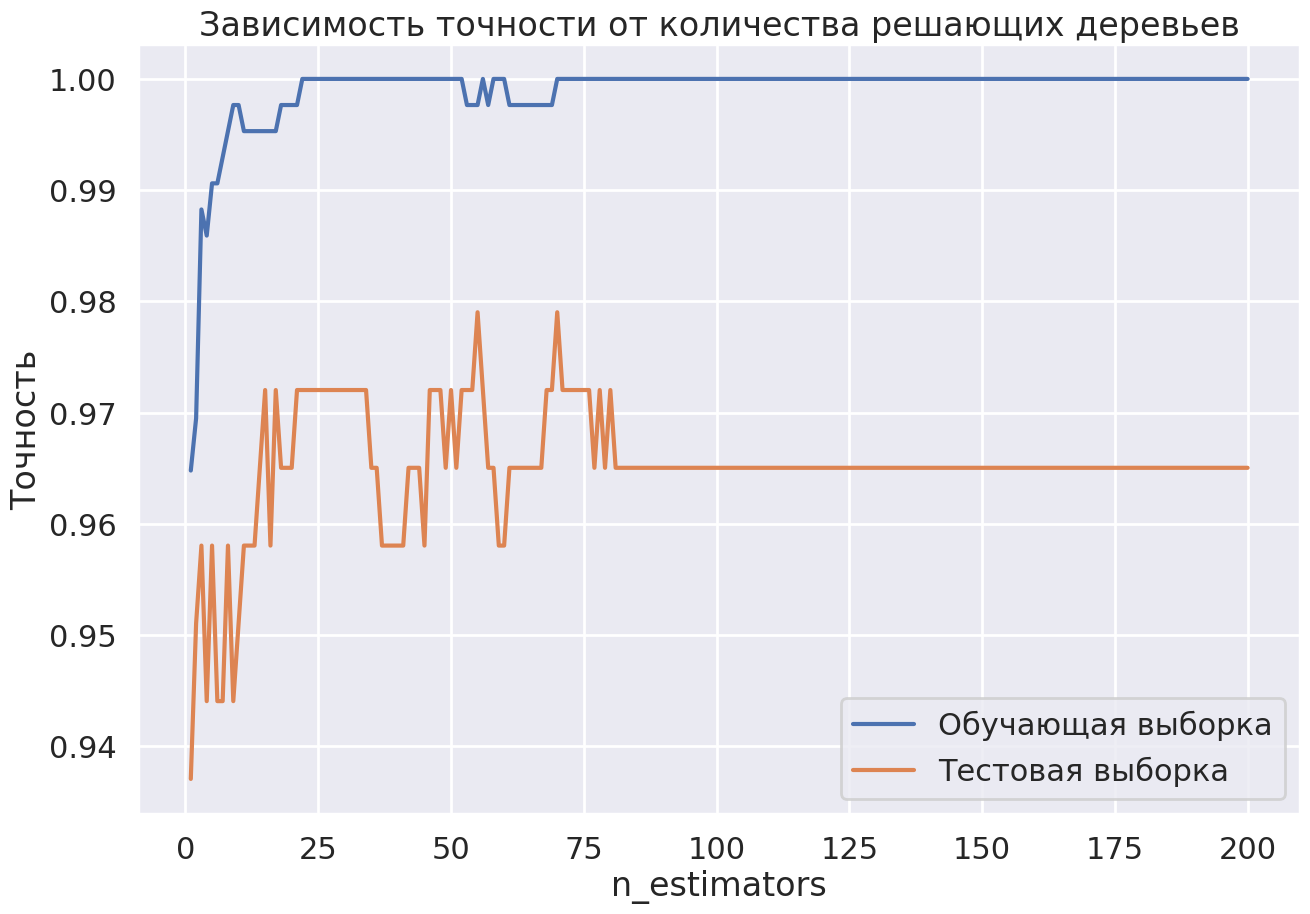

In [13]:
plt.figure(figsize = (15, 10))

plt.plot(n_estimators_values, train_accuracies, label = 'Обучающая выборка')
plt.plot(n_estimators_values, test_accuracies, label = 'Тестовая выборка')

plt.title('Зависимость точности от количества решающих деревьев')
plt.xlabel('n_estimators')
plt.ylabel('Точность')

plt.legend()
plt.grid(True)
plt.show()

**Выводы:**

1. На обучающей выборке точность увеличивается с увеличением числа деревьев, но после примерно 70 деревьев она выходит на плато. Это говорит о том, что добавление дополнительных деревьев не приводит к существенному увеличению точности на обучающей выборке.

2. На тестовой выборке также наблюдается увеличение точности с увеличением числа деревьев, но она выходит на плато примерно в районе значения 0.965. Это означает, что дальнейшее увеличение числа деревьев может не приносить значительного прироста точности на тестовой выборке из-за переобучения.

В теории, при предположении, что все решающие деревья в лесе независимы между собой, должно получаться, что при увеличении числа случайных решающих деревьев в лесе дисперсия предсказания монотонно снижается, а точность монотонно повышается. Однако из-за того, что на практике решающие деревья попарно скоррелированны, такой эффект наблюдается лишь до некоторого значения `n_estimators`, а затем значительных изменений не происходит.

Определите из графика оптимальное значение `n_estimators` и используйте это значение во всех последующих экспериментах с данным датасетом. Построим график зависимости `accuracy` от `min_samples_leaf` на обучающей и на тестовой выборках.

In [14]:
optimal_n_estimators = n_estimators_values[np.argmax(test_accuracies)]
print("Оптимальное количество деревьев:", optimal_n_estimators)

optimal_clf = RandomForestClassifier(n_estimators = optimal_n_estimators, random_state = 42)
optimal_clf.fit(X_train, y_train)

Оптимальное количество деревьев: 55


RandomForestClassifier(n_estimators=55, random_state=42)

In [15]:
min_samples_leaf_values = [1, 2, 4, 8, 16, 32]

train_accuracies_leaf = []
test_accuracies_leaf = []

for min_samples_leaf in min_samples_leaf_values:
    clf = RandomForestClassifier(n_estimators = optimal_n_estimators, min_samples_leaf = min_samples_leaf, random_state = 42)
    clf.fit(X_train, y_train)

    train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    train_accuracies_leaf.append(train_accuracy)

    test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_accuracies_leaf.append(test_accuracy)

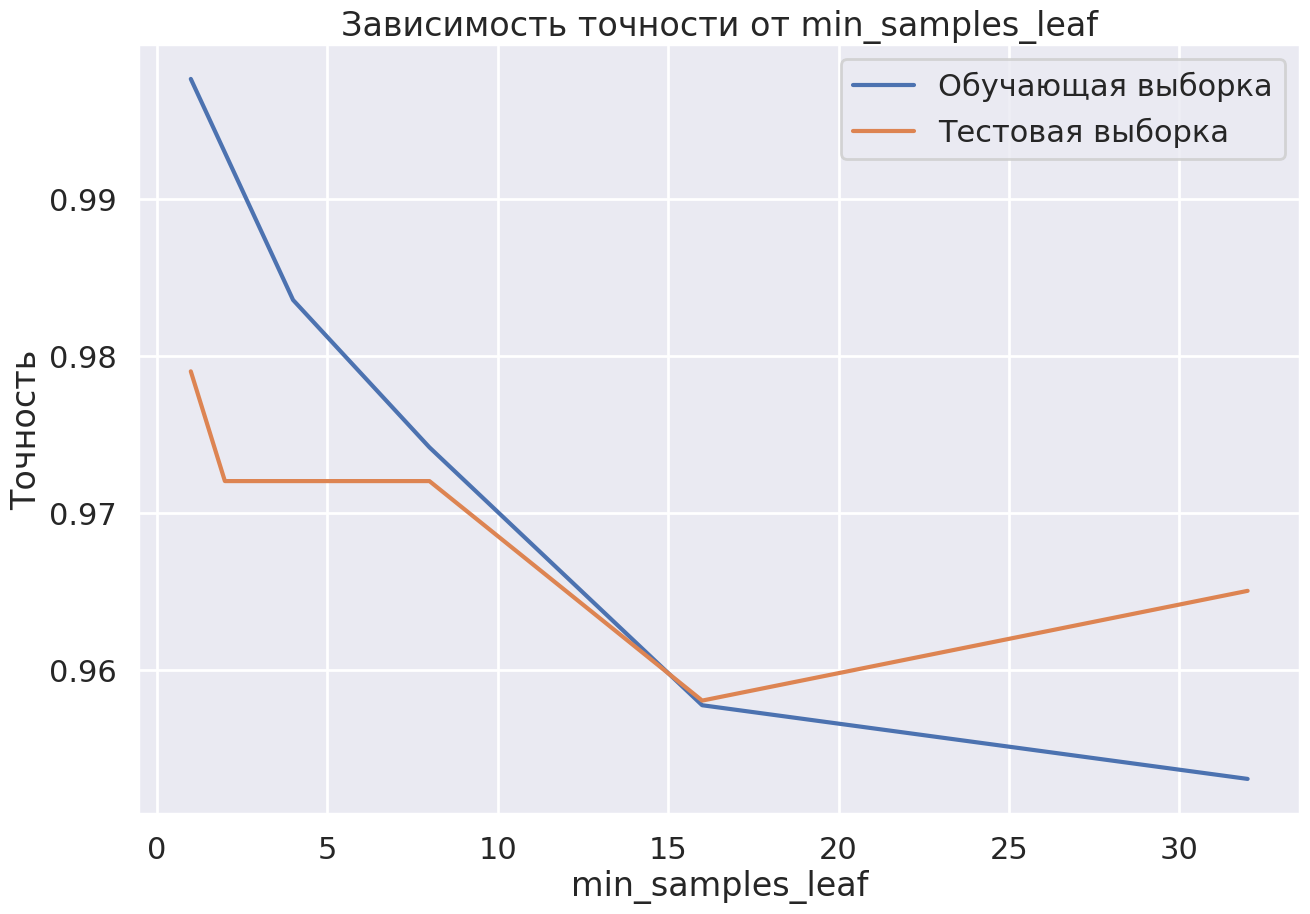

In [16]:
plt.figure(figsize = (15, 10))

plt.plot(min_samples_leaf_values, train_accuracies_leaf, label = 'Обучающая выборка')
plt.plot(min_samples_leaf_values, test_accuracies_leaf, label = 'Тестовая выборка')

plt.title('Зависимость точности от min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('Точность')

plt.legend()
plt.grid(True)
plt.show()

**Выводы:**

1. Точность на обучающей выборке убывает с увеличением min_samples_leaf до примерно значения 15. Это может указывать на то, что при увеличении минимального количества элементов в листе дерева модель становится более консервативной и менее склонной к переобучению, что снижает точность на обучающей выборке.

2. Однако на графике точности на тестовой выборке после перелома, примерно в том же месте, начинается рост точности с увеличением min_samples_leaf. Это может свидетельствовать о том, что при увеличении значения min_samples_leaf модель становится менее склонной к переобучению и лучше обобщает данные, что приводит к увеличению точности на тестовой выборке

Теперь повторим повторим эксперимент для параметра `min_samples_split`.

In [17]:
min_samples_split_values = [2, 5, 10, 20, 50]

train_accuracies_split = []
test_accuracies_split = []

for min_samples_split in min_samples_split_values:
    clf = RandomForestClassifier(n_estimators = optimal_n_estimators, min_samples_split = min_samples_split, random_state = 42)
    clf.fit(X_train, y_train)

    train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    train_accuracies_split.append(train_accuracy)

    test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_accuracies_split.append(test_accuracy)

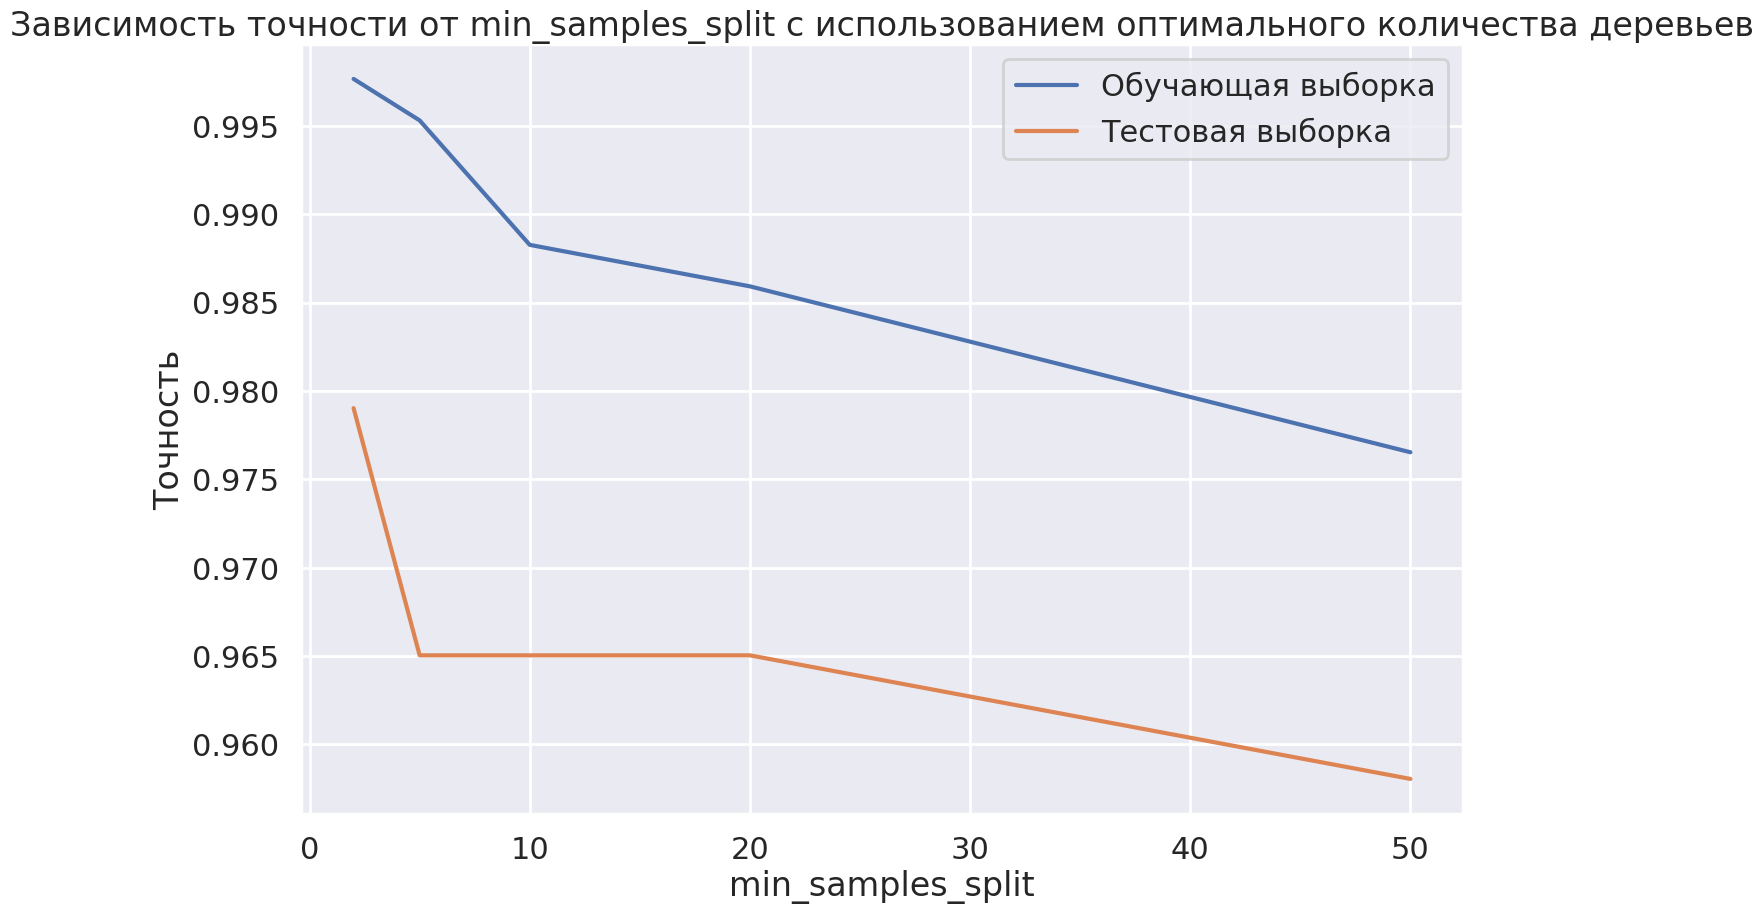

In [18]:
plt.figure(figsize = (15, 10))

plt.plot(min_samples_split_values, train_accuracies_split, label = 'Обучающая выборка')
plt.plot(min_samples_split_values, test_accuracies_split, label = 'Тестовая выборка')

plt.title('Зависимость точности от min_samples_split с использованием оптимального количества деревьев')
plt.xlabel('min_samples_split')
plt.ylabel('Точность')

plt.legend()
plt.grid(True)
plt.show()

**Выводы:**

1. Убывающая тенденция на обоих графиках говорит о том, что увеличение min_samples_split создает более простые деревья, что может снизить их способность к обобщению данных.

2. Высокая точность на обучающей выборке по сравнению с тестовой указывает на переобучение модели, где она слишком сильно настроена на тренировочные данные и плохо обобщает их на новые данные.

**Общие выводы по всей задаче:**

1. Количество деревьев (n_estimators) оказывает значительное влияние на точность модели. Мы определили оптимальное количество деревьев, которое обеспечивает хорошую точность на тестовой выборке, избегая переобучения.

2. Гиперпараметры min_samples_leaf и min_samples_split также влияют на точность модели. Увеличение этих параметров может уменьшить переобучение модели, но слишком большие значения могут привести к снижению точности на тестовой выборке.
